<a href="https://colab.research.google.com/github/madinak/image_captioning/blob/main/image_captioning_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
import collections
import pickle
import random
import numpy as np
import os
import time
import json
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Download and prepare dataset

In [ ]:
# Download training image files
train_image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + train_image_folder):
    train_image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
    train_path = os.path.dirname(train_image_zip) + train_image_folder
    os.remove(train_image_zip)
else:
    train_path = os.path.abspath('.') + train_image_folder

13510582272/13510573713 [==============================] - 804s 0us/step


In [ ]:
# Download validation image files
val_image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + val_image_folder):
    val_image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
    val_path = os.path.dirname(val_image_zip) + val_image_folder
    os.remove(val_image_zip)
else:
    val_path = os.path.abspath('.') + val_image_folder

6645022720/6645013297 [==============================] - 389s 0us/step


In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
    train_annot = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    val_annot = os.path.dirname(annotation_zip)+'/annotations/captions_val2014.json'
    os.remove(annotation_zip)

252887040/252872794 [==============================] - 16s 0us/step


In [ ]:
train_path = 'train2014/'

val_path = 'val2014/'

train_annot_path = 'annotations/captions_train2014.json'
val_annot_path = 'annotations/captions_val2014.json'

In [ ]:
with open(train_annot_path, 'r') as f:
    train_annot = json.load(f)

In [ ]:
with open(val_annot_path, 'r') as f:
    val_annot = json.load(f)

In [ ]:
# train images
train_images = train_annot['images']
train_captions = train_annot['annotations']

In [ ]:
# group train annotations by image
train_dict = collections.defaultdict(list)
for x in train_captions:
    caption = f"<start> {x['caption']} <end>"
    image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (x['image_id'])
    train_dict[image_path].append(caption)

In [ ]:
# validation
val_images = val_annot['images']
val_captions = val_annot['annotations']

In [ ]:
# group all val annotations by image
val_dict = collections.defaultdict(list)
for x in val_captions:
    
    caption = f"<start> {x['caption']} <end>"
    val_image_path = val_path + 'COCO_val2014_' + '%012d.jpg' % (x['image_id'])
    val_dict[val_image_path].append(caption)

In [ ]:
def filter_dict(dict_):
    new_dict = dict()
    # Iterate over all the items in dictionary
    for key, value in dict_.items():
      if len(value) == 5:
        new_dict[key] = value
    return new_dict

In [ ]:
final_train_dict = filter_dict(train_dict)
print('preprocessed captions lengths %d -> %d' % (len(train_dict.keys()), len(final_train_dict.keys())))

preprocessed captions lengths 82783 -> 82586


In [ ]:
final_val_dict = filter_dict(val_dict)
print('preprocessed captions lengths %d -> %d' % (len(val_dict.keys()), len(final_val_dict.keys())))

preprocessed captions lengths 40504 -> 40373


In [ ]:
print(len(list(final_train_dict.keys())))
print(len(list(final_val_dict.keys())))

82586
40373


In [ ]:
train_keys = list(final_train_dict.keys())

In [ ]:
valid_image_keys = list(final_val_dict.keys())
random.shuffle(valid_image_keys)

# Select the first 5000 image_paths for validation
val_keys = valid_image_keys[:5000]
print(len(val_keys))

# Select the last 5000 image_paths for test
test_keys = valid_image_keys[-5000:]
print(len(test_keys))

5000
5000


In [ ]:
# save as json for future use
with open('train_keys.json', 'w') as f:
    json.dump(train_keys, f)

In [ ]:
with open('val_keys.json', 'w') as f:
    json.dump(val_keys, f)

In [ ]:
with open('test_keys.json', 'w') as f:
    json.dump(test_keys, f)

In [ ]:
# open train_keys json 
with open('train_keys.json', 'r') as f:
    train_keys = json.load(f)

In [ ]:
# open val_keys json 
with open('val_keys.json', 'r') as f:
    val_keys = json.load(f)

In [ ]:
# open test_keys json 
with open('test_keys.json', 'r') as f:
    test_keys = json.load(f)

In [ ]:
def subset(data_dict, image_names):
    subset_dict = {image_name:captions for image_name, captions in data_dict.items() if image_name in image_names}
    return subset_dict

In [ ]:
train_data = dict(final_train_dict)
valid_data = subset(final_val_dict, val_keys)
test_data = subset(final_val_dict, test_keys)

In [ ]:
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of testing samples: ", len(test_data))

Number of training samples:  82586
Number of validation samples:  5000
Number of testing samples:  5000


In [ ]:
with open('train_data.json', 'w') as f:
    json.dump(train_data, f)

In [ ]:
with open('valid_data.json', 'w') as f:
    json.dump(valid_data, f)

In [ ]:
with open('test_data.json', 'w') as f:
    json.dump(test_data, f)

In [ ]:
# open train_data json 
with open('train_data.json', 'r') as f:
    train_data = json.load(f)

In [ ]:
# open valid_data json 
with open('valid_data.json', 'r') as f:
    valid_data = json.load(f)

In [ ]:
# open test_data json 
with open('test_data.json', 'r') as f:
    test_data = json.load(f)

## Pre-process captions

In [ ]:
train_paths = list(train_data.keys())
val_paths = list(valid_data.keys())

In [ ]:
train_c = []
train_i = []

for i in train_paths:
  train_caption_list = train_data[i]
  train_c.extend(train_caption_list)
  train_i.extend([i] * len(train_caption_list))

val_c = []
val_i = []

for i in val_paths:
  val_caption_list = valid_data[i]
  val_c.extend(val_caption_list)
  val_i.extend([i] * len(val_caption_list))

In [ ]:
all_c = train_c + val_c
all_i = train_i + val_i

In [ ]:
# with Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, 
                                                  oov_token="<unk>", 
                                                  lower=True,
                                                  split=' ',
                                                  filters='!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~')
tokenizer.fit_on_texts(all_c)
seqs = tokenizer.texts_to_sequences(all_c)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

# Find the maximum length of any caption
def max_caption_length(captions):
    return max(len(caption) for caption in captions)

# Calculate the max_length
max_length = max_caption_length(seqs)
max_length

52

In [ ]:
# save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
merge_dict = collections.defaultdict(list)
for image, caption in zip(all_i, cap_vector):
    merge_dict[image].append(caption)

In [ ]:
train_slice = []
val_slice = []

for i in all_i:
  if i[:i.index("/")] == 'train2014':
    train_slice.append(i)
  else:
    val_slice.append(i)

train_slice = set(train_slice)
val_slice = set(val_slice)
print('train length:', len(train_slice))
print('val length:', len(val_slice))

train length: 82586
val length: 5000


In [ ]:
train_images = []
train_captions = []
for imgt in train_slice:
    capt_len = len(merge_dict[imgt])
    train_images.extend([imgt] * capt_len)
    train_captions.extend(merge_dict[imgt])

val_images = []
val_captions = []
for imgv in val_slice:
    capv_len = len(merge_dict[imgv])
    val_images.extend([imgv] * capv_len)
    val_captions.extend(merge_dict[imgv])

len(train_images), len(train_captions), len(val_images), len(val_captions)

(412930, 412930, 25000, 25000)

## Transformer Model

### Prepare tf.data

In [ ]:
def load_image_captions(image_path, captions, size=(224, 224)):  
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = preprocess_input(image) 
    return image, captions

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_captions))
train_dataset = train_dataset.map(load_image_captions, 
                       num_parallel_calls=tf.data.experimental.AUTOTUNE) 
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_captions))
val_dataset = val_dataset.map(load_image_captions, 
                       num_parallel_calls=tf.data.experimental.AUTOTUNE) 
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [ ]:
# hyperparameters
num_layers = 4
d_model = 512
dff = 2048
num_heads = 8
vocabulary_size = tokenizer.num_words + 1
dropout_rate = 0.3

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.
    Returns:
      output, attention_weights
    """

    # (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(
        scaled_attention_logits,
        axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.3):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # (batch_size, input_seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        # (batch_size, input_seq_len, d_model)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        # (batch_size, input_seq_len, d_model)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection

        return out2


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                   maximum_position_encoding=49, dropout_rate=0.3):

        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        rs50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        
        self.features_extract = rs50
        
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
                
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) 
                           for _ in range(num_layers)]
    
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def train_resnet(self, trainable=False):
        for layer in self.features_extract.layers:
                layer.trainable = trainable
                
        
    def call(self, x, training, mask=None):
        x = self.features_extract(x)
        x = tf.reshape(x,
                    (x.shape[0], -1, x.shape[3]))

        seq_len = tf.shape(x)[1] 
        x = self.fc(x) 
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask=None)
        
        return x


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.3):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):

        attn1, attn_weights_block1 = self.mha1(
            x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) 

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
                 maximum_position_encoding, rate=0.3):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(
                                maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, 
                                                   padding_mask)

        attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, 
             vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                                     pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                             vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
         look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff, vocab_size=vocabulary_size, 
                          pe_input=49, pe_target=vocabulary_size, rate=dropout_rate)


In [ ]:
def create_masks(inp, tar):
    inp_seq = tf.ones([inp.shape[0], 49])
    enc_padding_mask = create_padding_mask(inp_seq)
    dec_padding_mask = create_padding_mask(inp_seq)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')

In [ ]:
train_loss_plot = []
train_acc_plot = []

val_loss_plot = []
val_acc_plot = []

In [ ]:
try:
    os.makedirs(os.path.join('checkpoints', 'trans'))
except FileExistsError:
    pass # if directory already exists
checkpoint_path = "./checkpoints/trans"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

## Training

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, 
                                     combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
@tf.function
def test_step(val_inp, val_tar):
    val_tar_inp = val_tar[:, :-1]
    val_tar_real = val_tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(val_inp, val_tar_inp)
    val_predictions, _ = transformer(val_inp, val_tar_inp, False, enc_padding_mask,
                                     combined_mask, dec_padding_mask)
    v_loss = loss_function(val_tar_real, val_predictions)

    val_loss(v_loss)
    val_accuracy(val_tar_real, val_predictions)

In [ ]:
EPOCHS = 20
patience = 5
wait = 0
best = 0

for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for batch, (inp, tar) in enumerate(train_dataset):
        train_step(inp, tar)

        # Log every 1000 batches.
        if batch % 1000 == 0:
            print("Training loss (for one batch) at batch %d: %.4f" % (batch, float(train_loss.result())))
            print("Training acc (for one batch) at batch %d: %.4f" % (batch, float(train_accuracy.result())))

    
    # Display metrics at the end of each epoch.
    #train_loss = train_loss.result()
    print("Training loss over epoch: %.4f" % (float(train_loss.result()),))

    #train_acc = train_accuracy.result()
    print("Training acc over epoch: %.4f" % (float(train_accuracy.result()),))

    train_loss_plot.append(train_loss.result())
    train_acc_plot.append(train_accuracy.result())

    # Reset training metrics at the end of each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()

    # Run a validation loop at the end of each epoch.
    for val_inp, val_tar in val_dataset:
        test_step(val_inp, val_tar)

    #val_loss = val_loss.result()
    #val_acc = val_accuracy.result()
    
    print("Validation loss: %.4f" % (float(val_loss.result()),))
    print("Validation acc: %.4f" % (float(val_accuracy.result()),))

    val_loss_plot.append(val_loss.result())
    val_acc_plot.append(val_accuracy.result())

    if (epoch + 1) % 5 == 0:
      checkpoint_path = ckpt_manager.save()
      print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_path}')

    print("Time taken: %.2fs" % (time.time() - start_time))
    val_loss.reset_states()
    val_accuracy.reset_states()

    # early stopping 
    wait += 1
    if val_loss > best:
      best = val_loss
      wait = 0
    if wait >= patience:
      break

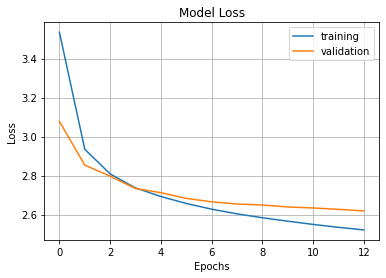

In [ ]:
plt.plot(train_loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
transformer.summary()

In [ ]:
# Restore from checkpoints

checkpoint_path = "./checkpoints/trans"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, 
                                          max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Inference

In [ ]:
def evaluate(image, max_length=21):
   image = tf.io.read_file(image)
   image = tf.io.decode_jpeg(image, channels=3)
   image = tf.image.resize(image, size=(224, 224))
   image = tf.expand_dims(image, axis=0)
   image = preprocess_input(image)
   
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0)
   result = []

   for i in range(max_length):
      enc_padding_mask, combined_mask, dec_padding_mask = create_masks(image, output)
      predictions, attention_weights = transformer(image, output, False, enc_padding_mask,
                                     combined_mask, dec_padding_mask)
      predictions = predictions[: ,-1:, :]
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result, tf.squeeze(output, axis=0), attention_weights

In [ ]:
# clean test captions
for key, captions in test_data.items():   
    for i, caption in enumerate (captions):
        caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
        clean_words = [word for word in caption_nopunct.split()]
        clean_words = clean_words[1:-1]
        caption_new = ' '.join(clean_words)
        captions[i] = caption_new

In [ ]:
# visualize
image = np.random.choice(test_keys)
caption, result, attention_weights = evaluate(image)
res_join = ' '.join(caption)
gt = test_data[image]

img = mpimg.imread(image)
h, w, _= np.shape(img)
img_plate=np.zeros((h, w + 150, 3), dtype=np.uint8) + 255
img_plate[0:h, 0:w, :] = img

dpi = 50
figsize = 0.8 * w / float(dpi), 0.8 * h / float(dpi)

fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.text(w + 20, 40, 'Ground truth:', fontsize=20)
ax.text(w + 20, 210, '\n'.join(gt), fontsize=18)

ax.text(w + 20, 270, 'Transformer:', fontsize=20)
ax.text(w + 20, 310, res_join, fontsize=18)

plt.axis('off')
plt.imshow(img_plate)

## Test evaluation

In [ ]:
def generate_test_captions(test_images, max_length=16):
    captions = []
    for i, image in tqdm(enumerate(test_images)):
        captions.append(evaluate(image, max_length)[0])

    return captions

In [ ]:
generated_captions = generate_test_captions(test_keys)

5000it [2:44:04,  1.97s/it]


In [ ]:
generated_captions[:2]

[['a', 'vase', 'with', 'flowers', 'sitting', 'on', 'a', 'table'],
 ['a', 'man', 'riding', 'a', 'horse', 'in', 'front', 'of', 'a', 'building']]

In [ ]:
join_cap = [' '.join(i) for i in generated_captions]
join_cap[:2]

['a vase with flowers sitting on a table',
 'a man riding a horse in front of a building']

In [ ]:
pred_captions = []

for i, j in zip(test_keys, join_cap):
    pred_captions.append({"image_id": int(i[27:33]), "caption": j})

In [ ]:
with open('pred_captions_trans.json', 'w') as fp:
    json.dump(pred_captions, fp)

In [ ]:
pred_captions[:2]

[{'caption': 'a vase with flowers sitting on a table', 'image_id': 248085},
 {'caption': 'a man riding a horse in front of a building',
  'image_id': 376208}]

In [ ]:
pip install pycocoevalcap

     |████████████████████████████████| 104.3 MB 1.2 MB/s 


In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')
import sys

input_json = sys.argv[1]


annFile = 'annotations/captions_val2014.json'
coco = COCO(annFile)
valids = coco.getImgIds()

load = json.load(open('pred_captions_trans.json', 'r'))

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [ ]:
# filter results to only those in MSCOCO validation set
preds_filt = [p for p in load if p['image_id'] in valids]
print('using %d/%d predictions' % (len(preds_filt), len(load)))
json.dump(preds_filt, open('tmp.json', 'w'))

using 5000/5000 predictions


In [ ]:
cocoRes = coco.loadRes(preds_filt)
cocoEval = COCOEvalCap(coco, cocoRes)
cocoEval.params['image_id'] = cocoRes.getImgIds()
cocoEval.evaluate()

# create output dictionary
out = {}
for metric, score in cocoEval.eval.items():
    out[metric] = score

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 48152, 'reflen': 47865, 'guess': [48152, 43152, 38152, 33152], 'correct': [30236, 13369, 5431, 2391]}
ratio: 1.0059960305024338
Bleu_1: 0.628
Bleu_2: 0.441
Bleu_3: 0.303
Bleu_4: 0.211
computing METEOR score...
METEOR: 0.203
computing Rouge score...
ROUGE_L: 0.462
computing CIDEr score...
CIDEr: 0.647
computing SPICE score...
SPICE: 0.128
